# Scikit-Learn binary classification model. Remote train via Azure ML Compute (AML Cluster) and optional HyperDrive (Hyper-parameter tunning with multiple child runs) 
_**This notebook showcases the creation of a ScikitLearn Binary classification model by remotely training on Azure ML Compute Target (AMLCompute Cluster).**_

_**It shows multiple ways of remote training like using a single Estimator, a ScriptRunConfig and hyper-parameter tunning with HyperDrive with multiple child trainings**_

## Check library versions
This is important when interacting with different executions between remote compute environments (cluster) and the instance/VM with the Jupyter Notebook.
If not using the same versions you can have issues when creating .pkl files in the cluster and downloading them to load it in the Jupyter notebook.

In [1]:
# Check versions
import azureml.core
import sklearn
import joblib
import pandas

print("Azure SDK version:", azureml.core.VERSION)
print('scikit-learn version is {}.'.format(sklearn.__version__))
print('joblib version is {}.'.format(joblib.__version__))
print('pandas version is {}.'.format(pandas.__version__))

Azure SDK version: 1.0.76
scikit-learn version is 0.20.3.
joblib version is 0.14.0.
pandas version is 0.23.4.


## Setup and connect to AML Workspace

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')


cesardl-automl-northcentralus-ws
automlpmdemo
northcentralus
102a16c3-37d3-48a8-9237-4c9b1e8e80e0


## Create An Experiment

**Experiment** is a logical container in an Azure ML Workspace. It hosts run records which can include run metrics and output artifacts from your experiments.

In [3]:
from azureml.core import Experiment
experiment_name = 'classif-attrition-amlcompute'
experiment = Experiment(workspace=ws, name=experiment_name)

## Introduction to AmlCompute

Azure Machine Learning Compute is managed compute infrastructure that allows the user to easily create single to multi-node compute of the appropriate VM Family. It is created **within your workspace region** and is a resource that can be used by other users in your workspace. It autoscales by default to the max_nodes, when a job is submitted, and executes in a containerized environment packaging the dependencies as specified by the user. 

Since it is managed compute, job scheduling and cluster management are handled internally by Azure Machine Learning service. 

For more information on Azure Machine Learning Compute, please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute)

**Note**: As with other Azure services, there are limits on certain resources (for eg. AmlCompute quota) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

### Create project directory and copy the training script into the project directory

Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script, and any additional files your training script depends on

In [4]:
import os
import shutil

project_folder = './classif-attrition-amlcompute'
os.makedirs(project_folder, exist_ok=True)

# Copy the training script into the project directory
shutil.copy('train.py', project_folder)

'./classif-attrition-amlcompute/train.py'

### Fetch the compute target 

We are going to use the compute target you had created before (make sure you provide the same name here in the variable `cpu_cluster_name`. 

In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cluster_name = "cesardl-cpu-clus"

cluster = ws.compute_targets[cluster_name]

### Fetch the AML Dataset

In [6]:
aml_dataset = ws.datasets['IBM-Employee-Attrition']

## Create Environment 
#### Optionally list all the available environments and packages in your AML Workspace

In [7]:
from azureml.core import Environment

envs = Environment.list(workspace=ws)

# List Environments and packages in my workspace
for env in envs:
    if env.startswith("AzureML"):
        print("Name",env)
        #print("packages", envs[env].python.conda_dependencies.serialize_to_string())
        
# Use curated environment from AML named "AzureML-Tutorial"
curated_environment = Environment.get(workspace=ws, name="AzureML-Tutorial")  # Custom environment: Environment.get(workspace=ws,name="myenv",version="1")

Name AzureML-Tutorial
Name AzureML-Minimal
Name AzureML-Chainer-5.1.0-GPU
Name AzureML-PyTorch-1.2-CPU
Name AzureML-TensorFlow-1.12-CPU
Name AzureML-TensorFlow-1.13-CPU
Name AzureML-PyTorch-1.1-CPU
Name AzureML-TensorFlow-1.10-CPU
Name AzureML-PyTorch-1.0-GPU
Name AzureML-TensorFlow-1.12-GPU
Name AzureML-TensorFlow-1.13-GPU
Name AzureML-Chainer-5.1.0-CPU
Name AzureML-PyTorch-1.0-CPU
Name AzureML-Scikit-learn-0.20.3
Name AzureML-PyTorch-1.2-GPU
Name AzureML-PyTorch-1.1-GPU
Name AzureML-TensorFlow-1.10-GPU
Name AzureML-PyTorch-1.3-GPU
Name AzureML-TensorFlow-2.0-CPU
Name AzureML-PyTorch-1.3-CPU
Name AzureML-TensorFlow-2.0-GPU
Name AzureML-PySpark-MmlSpark-0.15


## (Option A.) Configure & Run using ScriptRunConfig & Environment 
### (Easiest path using curated environments, but less flexible than Estimator..?)

In [40]:
# Add training script to run config
from azureml.core import ScriptRunConfig, RunConfiguration, Experiment

script_runconfig = ScriptRunConfig(source_directory=project_folder, 
                            script="train.py",
                            arguments=[aml_dataset.as_named_input('attrition')]
                           )

# Attach compute target to run config
script_runconfig.run_config.target = cluster
# runconfig.run_config.target = "local"

# Attach environment to run config
script_runconfig.run_config.environment = curated_environment

# Submit the Experiment Run to the AML Compute 
run = experiment.submit(script_runconfig)
run

Experiment,Id,Type,Status,Details Page,Docs Page
classif-attrition-amlcompute,classif-attrition-amlcompute_1578780432_feb64c59,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## (Option B.1.a) Configure an Estimator with specific pkgs versions (Using pip and conda) - Risky!
Risks: Overriding remote compute Docker image packages with pip and conda might cause issues with inconsistent package versions..

In [18]:
from azureml.train.estimator import Estimator
from azureml.train.sklearn import SKLearn

script_params = {
    '--solver': 'liblinear',
    '--penalty': 'l2'
}

pip_packages = [
                'azureml-defaults==1.0.76', 'azureml-core==1.0.76', 'azureml-telemetry==1.0.76',
                'azureml-dataprep==1.1.31', 'joblib==0.14.0', 'sklearn-pandas==1.7.0', 'pandas==0.23.4' 
               ]

# Using plain Estimator class
estimator = Estimator(source_directory=project_folder, 
                      script_params=script_params,
                      compute_target=cluster,
                      entry_script='train.py',
                      pip_packages=pip_packages,
                      conda_packages=['scikit-learn==0.20.3'],
                      inputs=[ws.datasets['IBM-Employee-Attrition'].as_named_input('attrition')])


# Using SKLearn estimator class
# estimator = SKLearn(source_directory=project_folder, 
#                     script_params=script_params,
#                     compute_target=cluster,
#                     entry_script='train.py',
#                     pip_packages=pip_packages,
#                     conda_packages=['scikit-learn==0.20.3'],
#                     inputs=[aml_dataset.as_named_input('attrition')])



## (Option B.1.b) Configure an Estimator with Environment (Better! Easier! Consistent!)

### Copy the curated environment to a new custom environment and register it into your Workspace
##### You can run this step just once since the custom Environment will be registered in your Workspace after this step. 

Need to copy the curated environment into a custom environment which will be updated by the Estimator.

If you try to directly use a curated environment with an Estimator you'll get the error:
Error: "Environment name can not start with the prefix AzureML. To alter a curated environment first create a copy of it."

#### This a potential PAPER-CUT: 
- Copying a curated environment to a custom environment and registering is not straight forward! You need to save Conda dependecies as a file, load it from there, etc.
- An Estimator should be able to use a curated environment, too.

In [23]:
# (CDLTLL) POTENTIAL PAPER-CUT: Copying a curated environment to a custom environment and registering is not straight forward!

# Save curated environment definition to folder (Two files, one for conda_dependencies.yml and another file for azureml_environment.json)
curated_environment.save_to_directory(path="./curated_environment_definition", overwrite=True)

# Create custom Environment from Conda specification file
custom_environment = Environment.from_conda_specification(name="custom-workshop-environment", file_path="./curated_environment_definition/conda_dependencies.yml")

# Save curated environment definition to folder (Two files, one for conda_dependencies.yml and another file for azureml_environment.json)
custom_environment.save_to_directory(path="./custom_environment_definition", overwrite=True)

custom_environment.register(ws)

envs = Environment.list(workspace=ws)

# List Environments and packages in my workspace
for env in envs:
    if env.startswith("custom"):
        print("Environment Name",env)
        print("packages", envs[env].python.conda_dependencies.serialize_to_string())

Environment Name custom-workshop-environment
packages channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.0.81.1
  - azureml-defaults==1.0.81
  - azureml-telemetry==1.0.81.1
  - azureml-train-restclients-hyperdrive==1.0.81
  - azureml-train-core==1.0.81
  - azureml-widgets==1.0.81
  - azureml-pipeline-core==1.0.81
  - azureml-pipeline-steps==1.0.81
  - azureml-opendatasets==1.0.81
  - azureml-automl-core==1.0.81.1
  - azureml-automl-runtime==1.0.81
  - azureml-train-automl-client==1.0.81.1
  - azureml-train-automl-runtime==1.0.81
  - azureml-train-automl==1.0.81
  - azureml-train==1.0.81
  - azureml-sdk==1.0.81
  - azureml-interpret==1.0.81
  - azureml-tensorboard==1.0.81
  - azureml-mlflow==1.0.81
  - mlflow
  - sklearn-pandas
- pandas
- numpy
- tqdm
- scikit-learn
- matplotlib
name: azureml_9c3b026f45c1aef228bf1fb00f90ec20



### Use Estimator with Custom Environment 

In [26]:
from azureml.train.estimator import Estimator
from azureml.train.sklearn import SKLearn

# Need to use custom environment with an Estimator as the Estimator will updated it when creating a Docker Image even if you don't have new pip or Conda packages.
# If you try to directly use a curated environment with an Estimator you'll get the error:
# Error: "Environment name can not start with the prefix AzureML. To alter a curated environment first create a copy of it."

# Load Custom Environment from Workspace
custom_environment = Environment.get(workspace=ws,name="custom-workshop-environment")  # ,version="1"
print(custom_environment)

script_params = {
    '--solver': 'liblinear',
    '--penalty': 'l2'
}

# Using plain Estimator class with custom Environment
estimator = Estimator(source_directory=project_folder, 
                      script_params=script_params,
                      compute_target=cluster,
                      # use_docker=True, #AML Cluster only supports Docker runs
                      entry_script='train.py',
                      environment_definition= custom_environment,
                      inputs=[ws.datasets['IBM-Employee-Attrition'].as_named_input('attrition')])

Environment(Name: custom-workshop-environment,
Version: 1)


WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


## (Option B.2) Run the experiment with a single Estimator (Optional Jump)
Jump this step if you want to use HyperDrive (Go to Option B2)

In [27]:
run = experiment.submit(estimator)
run

Experiment,Id,Type,Status,Details Page,Docs Page
classif-attrition-amlcompute,classif-attrition-amlcompute_1578779312_e9d88f9c,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## Monitor Run (Optional Jump)
Jump this step if you want to use HyperDrive (Go to Option B2)

In [28]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

Note: if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

#### Get log results upon completion
Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:

In [66]:
# run.wait_for_completion(show_output=True)  # specify True for a verbose log

## (Option B.2) Configure and Run with Intelligent hyperparameter tuning (HyperDrive using Estimator)
The adjustable parameters that govern the training process are referred to as the **hyperparameters** of the model. The goal of hyperparameter tuning is to search across various hyperparameter configurations and find the configuration that results in the best performance.

To demonstrate how Azure Machine Learning can help you automate the process of hyperarameter tuning, we will launch multiple runs with different values for numbers in the sequence. First let's define the parameter space using random sampling.

### Create a hyperparameter sweep
First, we will define the hyperparameter space to sweep over. 
In this example we will use random sampling to try different configuration sets of hyperparameters to maximize our primary metric, Accuracy.

In [30]:
# from azureml.train.hyperdrive import *
from azureml.train.hyperdrive import RandomParameterSampling, BayesianParameterSampling 
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform
    
# solver{'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
# penalty{'l1', 'l2', 'elasticnet', 'none'}, default='l2' --- Note that some penalty parameters are not supported by some algorithms..
param_sampling = RandomParameterSampling( {
    "--solver": choice('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    "--penalty": choice('l2')
    }
)

# Details on Scikit-Learn LogisticRegression hyper-parameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


Now we will define an early termination policy. The BanditPolicy basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.


In [31]:
early_termination_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)
# Note that early termination policy is currently NOT supported with Bayesian sampling
# Check here for recommendations on the multiple policies:
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters#picking-an-early-termination-policy

Now we are ready to configure a run configuration object, and specify the primary metric 'Accuracy' that's recorded in your training runs. 
If you go back to visit the training script, you will notice that this value is being logged. 
We also want to tell the service that we are looking to maximizing this value. 
We also set the number of samples to 20, and maximal concurrent job to 4.

In [51]:
# Note that in this case when using HyperDrive, the original Estimator's parameters are not used but the HyperDrive parameters...
hyperdrive_config = HyperDriveConfig(estimator=estimator, 
                                     # estimator=script_runconfig.run_config, 
                                     # pipeline=script_runconfig.run_config, # pipeline parameter is in Preview...
                                     hyperparameter_sampling=param_sampling, 
                                     policy=early_termination_policy,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=5,
                                     max_concurrent_runs=4)

# (CDLTLL)
# TO DO: Issues when trying to use the script_runconfig.run_config with HyperDriveConfig

Finally, lauch the hyperparameter tuning job.

In [52]:
# start the HyperDrive run
hyperdrive_run = experiment.submit(hyperdrive_config)

# Check here how to submit the hyperdrive run as a step of an AML Pipeline:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/intro-to-pipelines/aml-pipelines-parameter-tuning-with-hyperdrive.ipynb

The same input parameter(s) are specified in estimator/run_config script params and HyperDrive parameter space. HyperDrive parameter space definition will override these duplicate entries. ['--solver', '--penalty'] is the list of overridden parameter(s).


### Monitor HyperDrive run

Monitor the progress of the runs with the Jupyter widget.

In [53]:
from azureml.widgets import RunDetails
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSE…

#### Get log results upon completion
Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:

In [16]:
# hyperdrive_run.wait_for_completion(show_output=True)

### Find and get the best model found by HyperDrive¶ 
When all jobs finish, we can find out the one that has the highest accuracy.

In [35]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])
# print(best_run.get_details())


['--penalty', 'l2', '--solver', 'newton-cg']


In [36]:
# Copy 'best_run' to 'run' to re-use the same code also used without HyperDrive
run = best_run

## Display run metrics results
You now have a model trained on a remote cluster. Retrieve the accuracy of the model:

In [37]:
print(run.get_metrics())

{'Accuracy': 0.8741496598639455}


## See files associated with the run

In [38]:
print(run.get_file_names())

run.download_file('azureml-logs/70_driver_log.txt')

['azureml-logs/55_azureml-execution-tvmps_bcb36db862e3c9e906c8553abcb0c1d35a8229810ba8acf1830ab57fe25cc9d1_d.txt', 'azureml-logs/65_job_prep-tvmps_bcb36db862e3c9e906c8553abcb0c1d35a8229810ba8acf1830ab57fe25cc9d1_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_bcb36db862e3c9e906c8553abcb0c1d35a8229810ba8acf1830ab57fe25cc9d1_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/153_azureml.log', 'logs/azureml/azureml.log', 'outputs/classif-empl-attrition.pkl', 'outputs/x_test.pkl', 'outputs/y_test.pkl']


## Register the model
Once you've trained the model, you can save and register it to your workspace. Model registration lets you store and version your models in your workspace to simplify model management and deployment.

Running the following code will register the model to your workspace, and will make it available to reference by name in remote compute contexts or deployment scripts. 

In [23]:
from azureml.core.model import Model

model_reg = run.register_model(model_name='classif-empl-attrition-aml-comp',    # Name of the registered model in your workspace.
                               description='Binary classification model for employees attrition',
                               model_path='outputs/classif-empl-attrition.pkl', # Local file to upload and register as a model.
                               model_framework=Model.Framework.SCIKITLEARN,     # Framework used to create the model.
                               model_framework_version='0.20.3',                # Version of scikit-learn used to create the model.
                               tags={'ml-task': "binary-classification", 'business-area': "HR"},
                               properties={'joblib-version': "0.14.0", 'pandas-version': "0.23.4"},
                               sample_input_dataset=aml_dataset
                              )
model_reg

Model(workspace=Workspace.create(name='cesardl-automl-northcentralus-ws', subscription_id='102a16c3-37d3-48a8-9237-4c9b1e8e80e0', resource_group='automlpmdemo'), name=classif-empl-attrition-aml-comp, id=classif-empl-attrition-aml-comp:24, version=24, tags={'ml-task': 'binary-classification', 'business-area': 'HR'}, properties={'joblib-version': '0.14.0', 'pandas-version': '0.23.4'})

### Download Scikit-Learn model pickle file from the run (Option A)

In [24]:
# retrieve model for visualization and deployment

# Download the model .pkl file to local (Using the 'run' object)
run.download_file('outputs/classif-empl-attrition.pkl')

### Download Scikit-Learn model pickle file from the model registry (Option B)

In [25]:
print(Model.get_model_path('classif-empl-attrition-aml-comp', _workspace=ws))

model_from_registry = Model(ws,'classif-empl-attrition-aml-comp')
model_from_registry.download(target_dir='.', exist_ok=True)


azureml-models/classif-empl-attrition-aml-comp/24/classif-empl-attrition.pkl


'classif-empl-attrition.pkl'

# Deploy model into ACI

In [31]:
###################################
# TO DO:
# service_name = 'attrition-svc'
# service = Model.deploy(ws, service_name, [model_reg])
# service.run()

# Try model predictions in this notebook

### Load model into memory

In [22]:
# Load the model into memory
model = joblib.load('classif-empl-attrition.pkl')

model

Pipeline(memory=None,
     steps=[('preprocessor', DataFrameMapper(default=False, df_out=False,
        features=[(['Age'], Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, wit...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [23]:
# Load model and test datasets from .pkl files

# Download the test datasets to local
run.download_file('outputs/x_test.pkl')
run.download_file('outputs/y_test.pkl')

# Load the test datasets into memory
x_test = joblib.load('x_test.pkl')
y_test = joblib.load('y_test.pkl')

# joblib
# https://joblib.readthedocs.io/en/latest/installing.html
# https://joblib.readthedocs.io/en/latest/generated/joblib.load.html

## Make Predictions and calculate Accuracy metric

In [24]:
from sklearn.metrics import accuracy_score

# Make Multiple Predictions
y_predictions = model.predict(x_test)  # .predict(X[0:1])

y_predictions

print('Accuracy:')
accuracy_score(y_test, y_predictions)



Accuracy:


0.8741496598639455

## Confusion Matrix

[[243   4]
 [ 33  14]]


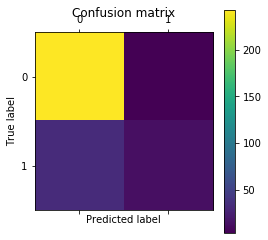

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predictions)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
# One Prediction
instance_num = 6
# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = model.predict(x_test)[instance_num]

print("One Prediction: ")
print(prediction_value)

print("20 Predictions: ")
print(y_predictions[:20])

x_test.head(20)

One Prediction: 
0
20 Predictions: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
899,49,Travel_Rarely,1098,Research & Development,4,2,Medical,1,Male,85,...,3,3,1,23,2,4,1,0,0,0
610,27,Travel_Rarely,269,Research & Development,5,1,Technical Degree,3,Male,42,...,3,2,1,9,3,3,9,8,0,8
667,41,Travel_Rarely,1085,Research & Development,2,4,Life Sciences,2,Female,57,...,3,3,1,10,1,2,7,7,1,0
857,44,Travel_Rarely,1097,Research & Development,10,4,Life Sciences,3,Male,96,...,3,3,0,6,4,3,6,4,0,2
1063,29,Travel_Rarely,1246,Sales,19,3,Life Sciences,3,Male,77,...,3,3,2,10,3,3,10,7,0,4
1022,37,Non-Travel,1413,Research & Development,5,2,Technical Degree,3,Male,84,...,3,1,0,7,2,1,6,5,1,3
665,47,Travel_Rarely,1454,Sales,2,4,Life Sciences,4,Female,65,...,3,1,0,3,3,2,3,2,1,2
840,35,Travel_Rarely,982,Research & Development,1,4,Medical,4,Male,58,...,3,2,1,10,2,3,8,0,1,7
796,25,Travel_Rarely,1219,Research & Development,4,1,Technical Degree,4,Male,32,...,3,2,1,7,3,4,7,7,5,6
1221,45,Non-Travel,1238,Research & Development,1,1,Life Sciences,3,Male,74,...,4,4,1,25,3,2,23,15,14,4


In [30]:
y_test.head(5)

899     0
610     0
667     1
857     1
1063    0
Name: Attrition, dtype: int64